# Análisis Exploratorio de Imágenes (EDA)

En esta sección se lleva a cabo un análisis exploratorio de las imágenes proporcionadas por el dataset ODIR-5K, cuyo objetivo principal es la detección automática de patologías oculares mediante aprendizaje profundo. El conjunto de datos incluye imágenes de fondo de ojo (retinografías) correspondientes a ambos ojos (izquierdo y derecho) de cada paciente, junto con sus respectivas etiquetas diagnósticas:

    - Normal (N)
    - Diabetes (D)
    - Glaucoma (G)
    - Cataract (C)
    - Age related Macular Degeneration (A)
    - Hypertension (H)
    - Pathological Myopia (M)
    - Other diseases/abnormalities (O)

El propósito de este análisis es examinar la estructura, calidad y disponibilidad de las imágenes, así como identificar posibles inconsistencias, variaciones en el tamaño o el formato, diferencias de contraste o brillo, y cualquier otra característica relevante que pueda impactar en la fase de preprocesamiento y entrenamiento del modelo.

In [ ]:
# Importación de librerías
import pandas as pd      # Manejo de datos tabulares (DataFrames)
import numpy as np       # Operaciones numéricas y arrays
import os                # Manejo de rutas y archivos
import cv2               # Lectura y procesamiento de imágenes
import random            # Selección aleatoria
import matplotlib.pyplot as plt  # Visualización de gráficos e imágenes
import seaborn as sns    # Gráficos estadísticos mejorados
from collections import Counter  # Conteo de elementos
from tqdm import tqdm    # Barra de progreso en bucles
from scipy.stats import ttest_ind  # Prueba estadística t para comparación de medias

### Carga y vista general dataset
En este apartado se realiza la carga inicial del dataset ODIR-5K y una exploración básica de su contenido.

In [52]:
# Carga del dataset
df = pd.read_excel("../EDA/data.xlsx")

# Dimendión y primeras filas del dataset
print("Dataset shape:", df.shape)
df.head(10)

Dataset shape: (3500, 15)


ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   
5   5           50      Female  5_left.jpg  5_right.jpg   
6   6           60        Male  6_left.jpg  6_right.jpg   
7   7           60      Female  7_left.jpg  7_right.jpg   
8   8           59        Male  8_left.jpg  8_right.jpg   
9   9           54        Male  9_left.jpg  9_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   
5             moderate non proliferative retinopathy   
6                        macular epiretinal membrane   
7                                             drusen   
8                                      normal fundus   
9                                      normal fundus   

                           Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                                      normal fundus  0  0  0  1  0  0  0  0  
1                                      normal fundus  1  0  0  0  0  0  0  0  
2             moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3                    branch retinal artery occlusion  0  0  0  0  0  0  0  1  
4                  mild nonproliferative retinopathy  0  1  0  0  0  0  0  1  
5             moderate non proliferative retinopathy  0  1  0  0  0  0  0  0  
6  moderate non proliferative retinopathy，epireti...  0  1  0  0  0  0  0  1  
7                  mild nonproliferative retinopathy  0  1  0  0  0  0  0  1  
8                                      normal fundus  1  0  0  0  0  0  0  0  
9                              vitreous degeneration  0  0  0  0  0  0  0  1

In [53]:
# Información básica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         3500 non-null   int64 
 1   Patient Age                3500 non-null   int64 
 2   Patient Sex                3500 non-null   object
 3   Left-Fundus                3500 non-null   object
 4   Right-Fundus               3500 non-null   object
 5   Left-Diagnostic Keywords   3500 non-null   object
 6   Right-Diagnostic Keywords  3500 non-null   object
 7   N                          3500 non-null   int64 
 8   D                          3500 non-null   int64 
 9   G                          3500 non-null   int64 
 10  C                          3500 non-null   int64 
 11  A                          3500 non-null   int64 
 12  H                          3500 non-null   int64 
 13  M                          3500 non-null   int64 
 14  O       

### Análisis estructural de las imégens

En esta sección se analizá las dimensiones (alto, ancho y número de canales) de las imágenes del dataset, así como la orientación de las mismas, y detección de imágenes corruptas. Este análisis permite identificar la variedad de tamaños presentes, detectar posibles inconsistencias y establecer criterios adecuados para el preprocesamiento y la normalización de las imágenes antes del entrenamiento del modelo.


In [54]:
# Ruta de las imágenes
image_dir = "../ODIR-5K/ODIR-5K/Training Images"

In [55]:
# Función para obtener las dimensiones de las imágenes y detectar archivos corruptos
def get_image_sizes(image_paths):
    """
    Analiza las rutas de los archivos de imagen para extraer sus dimensiones e identificar imágenes corruptas.

    Parámetros:
        image_paths (lista de str): Lista de rutas completas a los archivos de imagen.

    Devuelve:
        size_counts: Tamaños de imagen (H, W, C) como claves y su frecuencia como valores.
        corrupted: Lista de rutas de archivos correspondientes a imágenes que no se pudieron leer.
    """
    sizes = []
    corrupted = []

    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            h, w, c = img.shape
            sizes.append((h, w, c))
        else:
            corrupted.append(path)

    size_counts = Counter(sizes)
    return size_counts, corrupted

Vemos los 15 tamaños de imagen más comunes y el número total de imágenes corruptas identificadas.

In [57]:
# Construir lista de rutas a todas las imágenes (izquierda y derecha)
left_paths = df['Left-Fundus'].apply(lambda x: os.path.join(image_dir, x)).tolist()
right_paths = df['Right-Fundus'].apply(lambda x: os.path.join(image_dir, x)).tolist()

# Unir ambas listas
image_paths = left_paths + right_paths

# Obtener tamaños y detectar corruptas
size_counts, corrupted_images = get_image_sizes(image_paths)

# Mostrar los 15 tamaños más comunes
print("Tamaños de imagen más comunes:\n")
for size, count in size_counts.most_common(15):
    print(f"{size}: {count} imágenes")

# Mostrar imágenes corruptas
print(f"\nNúmero de imágenes corruptas: {len(corrupted_images)}")

Tamaños de imagen más comunes:

(1728, 2592, 3): 2146 imágenes
(1536, 2048, 3): 524 imágenes
(1728, 2304, 3): 424 imágenes
(1934, 1956, 3): 390 imágenes
(1824, 2736, 3): 344 imágenes
(1296, 1936, 3): 284 imágenes
(1444, 1444, 3): 267 imágenes
(2304, 3456, 3): 258 imágenes
(1984, 2976, 3): 212 imágenes
(1152, 1536, 3): 198 imágenes
(2448, 3264, 3): 170 imágenes
(2056, 2124, 3): 146 imágenes
(2592, 3888, 3): 124 imágenes
(2976, 2976, 3): 124 imágenes
(2000, 2584, 3): 107 imágenes

Número de imágenes corruptas: 0


Se observa que las imágenes presentan una notable variabilidad en sus dimensiones, con más de 15 tamaños diferentes.
El formato más frecuente es (1728, 2592, 3), en 2.146 imágenes, seguido por otras resoluciones como (1536, 2048, 3) y (1728, 2304, 3).

Será necesario aplicar un proceso de redimensionado uniforme durante el preprocesamiento, que permita:

- Establecer una entrada consistente para el modelo (redes convolucionales como ResNet o EfficientNet requieren una resolución fija).

- Aumentar la eficiencia computacional reduciendo el tamaño de las imágenes más grandes.

- Evitar errores o inconsistencias en los DataLoaders al trabajar con batches.

Por otro lado, no se han identificado imágenes corruptas, lo que confirma que todos los archivos pueden ser leídos correctamente y están disponibles para su procesamiento posterior.

In [ ]:
# Muestra una selección aleatoria de imágenes 
def show_random_images(df, image_dir, n=15):
    """
    Muestra una selección aleatoria de imágenes del dataset.

    Parámetros:
        df: DataFrame con columnas 'Left-Fundus' y 'Right-Fundus'.
        image_dir: Ruta donde están las imágenes.
        n: Número de imágenes a mostrar.
    """
    # Unir ambas columnas en una lista larga de nombres de archivos
    all_images = pd.concat([df['Left-Fundus'], df['Right-Fundus']], ignore_index=True)
    
    # Seleccionar aleatoriamente n imágenes
    sample = all_images.sample(n=n, random_state=42).reset_index(drop=True)

    cols = 5
    rows = n // cols + 1

    plt.figure(figsize=(15, 3 * rows))

    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        path = os.path.join(image_dir, sample[i])
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.title(sample[i])

    plt.tight_layout()
    plt.show()


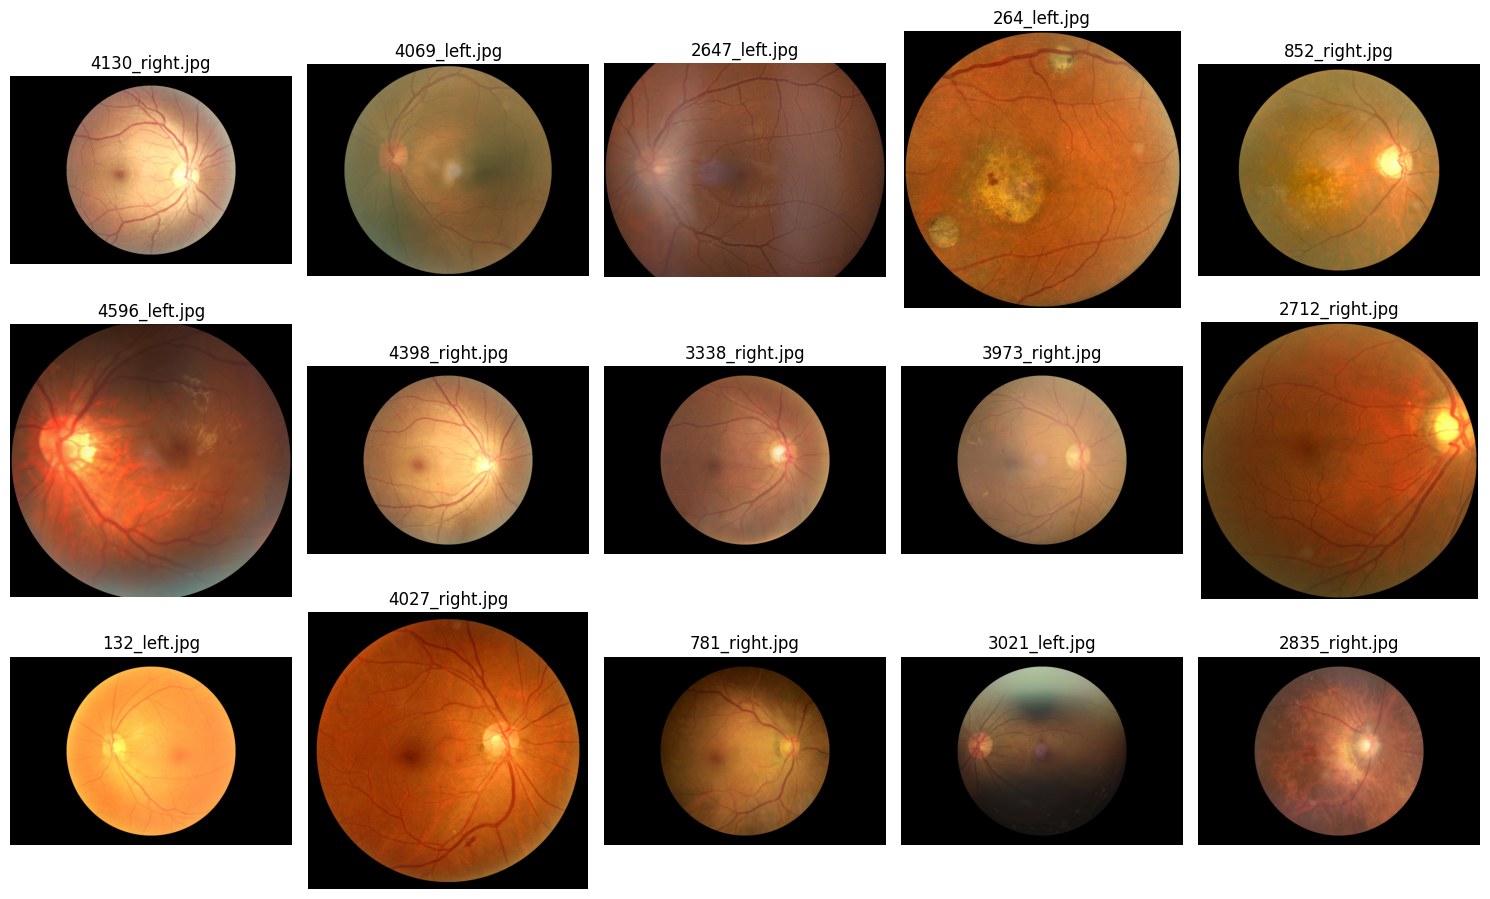

In [ ]:
show_random_images(df, image_dir, n=15)

Se observa una variabilidad en la orientación de las imágenes: en algunas, la mácula aparece a la izquierda y en otras a la derecha, y también hay rotaciones leves debidas a diferencias en la captura.
Para que el modelo no dependa de la posición anatómica exacta y pueda generalizar mejor, podríamos aplicar en el preprocesado:

`RandomHorizontalFlip()` para compensar la simetría entre ojos.

`RandomRotation()` para simular variaciones reales de inclinación.

In [ ]:
# Preparacion de DataFrames para visualizacion 
df_shapes = pd.DataFrame(size_counts.items(), columns=['tamaño', 'total'])
df_shapes = df_shapes.sort_values('total', ascending=False).reset_index(drop=True)

# Añadir columna de frecuencia acumulada
df_shapes['acumulado'] = df_shapes['total'].cumsum()

df_shapes

tamaño  total  acumulado
0    (1728, 2592, 3)   2146       2146
1    (1536, 2048, 3)    524       2670
2    (1728, 2304, 3)    424       3094
3    (1934, 1956, 3)    390       3484
4    (1824, 2736, 3)    344       3828
..               ...    ...        ...
96     (718, 770, 3)      1       6996
97   (1422, 1892, 3)      1       6997
98     (783, 960, 3)      1       6998
99     (705, 758, 3)      1       6999
100    (799, 925, 3)      1       7000

[101 rows x 3 columns]

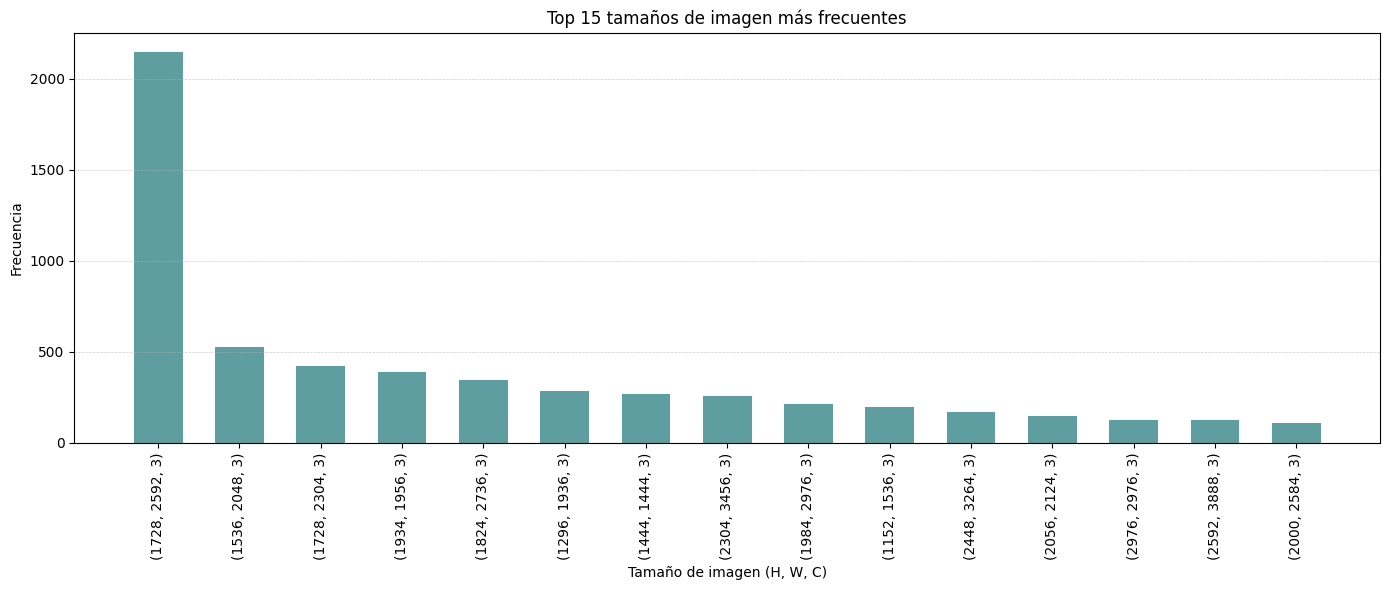

In [ ]:
# Visualización de la distribución de los tamaños de imagen más comunes
# Ordenar por frecuencia descendente 
df_shapes = df_shapes.sort_values(by='total', ascending=False)

# filtrar los tamaños más frecuentes 
top_n = 15
df_cut = df_shapes.head(top_n)

# crear figura
plt.figure(figsize=(14, 6))

# Etiquetas de tamaños (H, W, C)
x_labels = [str(shape) for shape in df_cut['tamaño']]
x = range(len(df_cut))

# Gráfico de barras
plt.bar(x, df_cut['total'], width=0.6, color='cadetblue')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

# Personalización del gráfico
plt.xticks(x, x_labels, rotation=90)
plt.xlabel("Tamaño de imagen (H, W, C)")
plt.ylabel("Frecuencia")
plt.title(f"Top {top_n} tamaños de imagen más frecuentes")
plt.tight_layout()

plt.show()

### Análisis de color de las imágenes

Se procede a evaluar posibles variaciones en el brillo, contraste y distribución del color, con el objetivo de considerar su impacto en las etapas posteriores de preprocesamiento, especialmente en lo relativo a la normalización y la aplicación de técnicas de data augmentation.

Por ejemplo, en el contexto de la detección de retinopatía diabética y edema macular diabético, resulta especialmente relevante la información contenida en los canales rojo y verde, ya que permiten identificar con mayor precisión signos clínicos como microhemorragias y exudados.

Se analiza en primer lugar los grises para detectar sobreeexposicion , contraste y dominancia de fondos negros. 

In [ ]:
# Histograma normalizado de niveles de gris (%)
def compute_grayscale_histogram(image_path):
    """
    Calcula el histograma promedio normalizado (en %) de niveles de gris
    a partir de una lista de rutas a imágenes.

    Parámetros:
        image_path (list of str): Lista de rutas a archivos de imagen (.jpg, .png, etc.).

    Devuelve:
        hist_total (np.ndarray): Histograma promedio de intensidad en escala de grises,
            normalizado como porcentaje (256 valores).
        num_validas (int): Número de imágenes válidas procesadas.
    """
    hist_total = np.zeros(256)
    valid_img = 0

    for path in image_path:
        img = cv2.imread(path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()
        hist_total += hist
        valid_img += 1

    if hist_total.sum() > 0:
        hist_total = (hist_total / hist_total.sum()) * 100  # Convertir a porcentaje

    return hist_total, valid_img

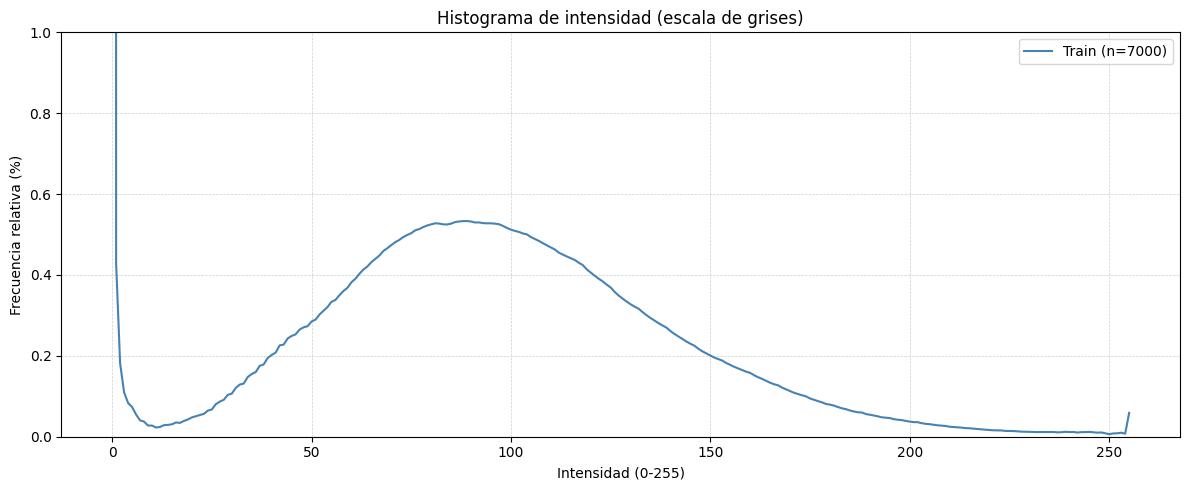

In [ ]:
# Aplicamos la función al conjunto de imágenes
hist_grey, num_img = compute_grayscale_histogram(image_paths)

# Visualización del histograma promedio de niveles de gris
plt.figure(figsize=(12, 5))
plt.plot(hist_grey, label=f'Train (n={num_img})', color='steelblue')
plt.title("Histograma de intensidad (escala de grises)")
plt.xlabel("Intensidad (0-255)")
plt.ylabel("Frecuencia relativa (%)")
plt.ylim(0, 1.0) 
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


Las intensidades medias, comprendidas aproximadamente entre los valores 50 y 150, suelen corresponder a la región central del fondo de ojo (retina), donde se concentra la mayor parte de la información clínica relevante. Por el contrario, las intensidades más bajas están asociadas a áreas periféricas oscuras o al fondo negro de la imagen, las cuales carecen de valor diagnóstico.

Con el objetivo de resaltar las estructuras anatómicas relevantes y mejorar el contraste entre regiones informativas y no informativas, se podría valorar aplicar la transformación `ColorJitter()` durante la fase de preprocesamiento. Esta técnica permite ajustar de forma aleatoria parámetros como el brillo, el contraste y la saturación, lo cual puede facilitar la detección de las diferentes patologías.

A continuación, se lleva a cabo el análisis de los canales de color Rojo, Verde y Azul (RGB) para examinar la distribución de intensidades y posibles desequilibrios cromáticos en las imágenes.

In [ ]:
# Análisis promedio de histograma por canal RGB en imágenes
def compute_rgb_histogram(image_path):
    """
    Calcula el histograma promedio de los canales RGB (Rojo, Verde y Azul) 
    a partir de una lista de imágenes.

    Parámetros:
        image_path (list of str): Rutas de las imágenes en formato .jpg.

    Devuelve:
        b_hist, g_hist, r_hist (np.ndarray): Histogramas promedio de los canales Azul, Verde y Rojo.
    """

    b_hist = np.zeros(256)
    g_hist = np.zeros(256)
    r_hist = np.zeros(256)
    valid_count = 0  

    for path in tqdm(image_path):
        img = cv2.imread(path)
        if img is None:
            continue  
        valid_count += 1

        # Separar canales
        b_channel = img[:, :, 0]
        g_channel = img[:, :, 1]
        r_channel = img[:, :, 2]

        # Calcular histogramas y acumular
        b_hist += cv2.calcHist([b_channel], [0], None, [256], [0, 256]).ravel()
        g_hist += cv2.calcHist([g_channel], [0], None, [256], [0, 256]).ravel()
        r_hist += cv2.calcHist([r_channel], [0], None, [256], [0, 256]).ravel()

    # Calcular promedios
    if valid_count > 0:
        b_hist /= valid_count
        g_hist /= valid_count
        r_hist /= valid_count

    return b_hist, g_hist, r_hist


In [ ]:
# Cálculo de histogramas RGB para las imágenes del dataset
image_b_hist, image_g_hist, image_r_hist = compute_rgb_histogram(image_paths)

100%|██████████| 7000/7000 [03:58<00:00, 29.37it/s]


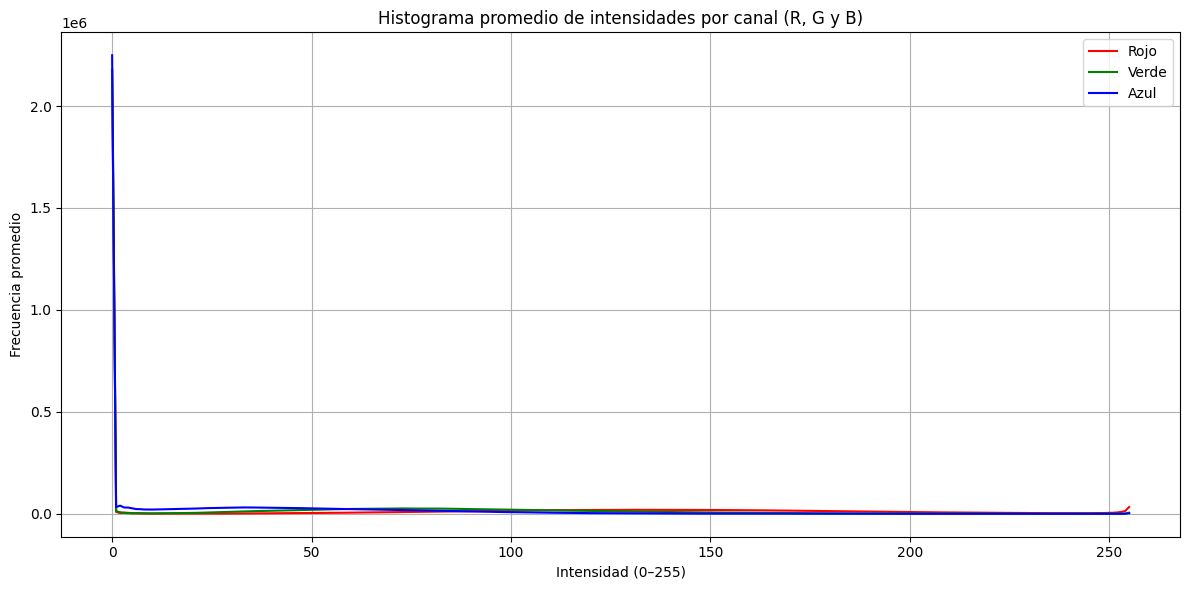

In [ ]:
# visualización del histograma promedio de intensidades por canal RGB
plt.figure(figsize=(12, 6))

# Canal Rojo
plt.plot(image_r_hist, color='red', label='Rojo')

# Canal Verde
plt.plot(image_g_hist, color='green', label='Verde')

# Canal Azul
plt.plot(image_b_hist, color='blue', label='Azul')

plt.title("Histograma promedio de intensidades por canal (R, G y B)")
plt.xlabel("Intensidad (0–255)")
plt.ylabel("Frecuencia promedio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Normalizamos los histogramas de color RGB para el conjunto de datos, de forma que las frecuencias se expresen en porcentaje. Luego, se grafican los histogramas normalizados a porcentaje para los canales Rojo, Verde y Azul, permitiendo ver visualmente la distribución de intensidades de color. 

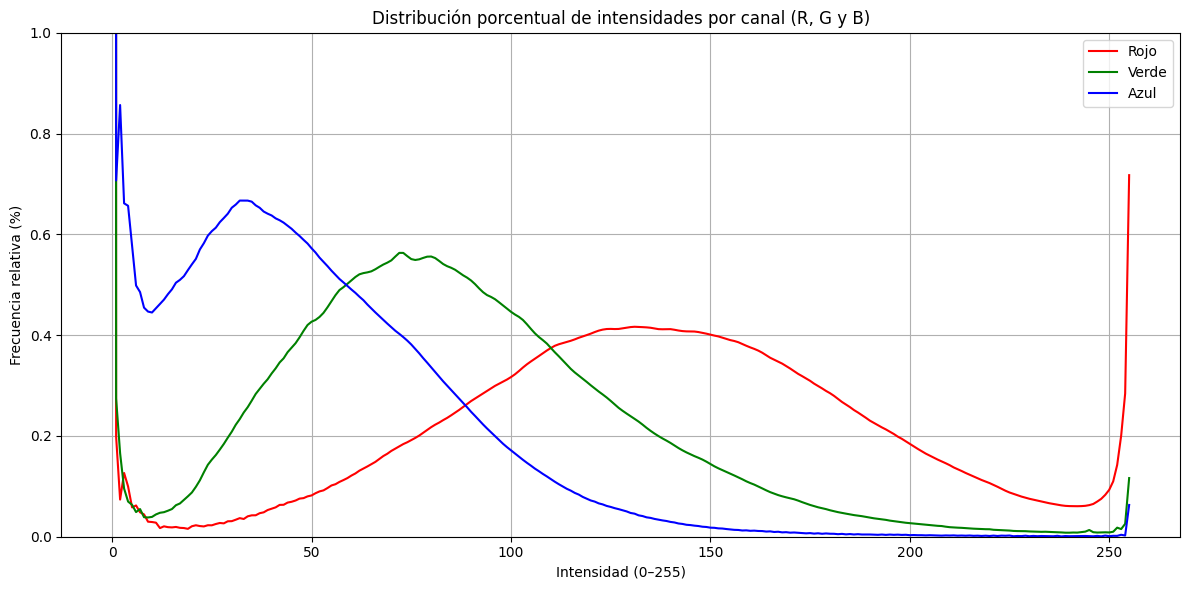

In [ ]:
# Funcióm para normalizar el histograma
def normalize_histogram_percent(hist):
    return hist / hist.sum() * 100  

# Normalizamos todos los canales
r_hist_norm = normalize_histogram_percent(image_r_hist)
g_hist_norm = normalize_histogram_percent(image_g_hist)
b_hist_norm = normalize_histogram_percent(image_b_hist)

# Graficamos los histogramas normalizados
plt.figure(figsize=(12, 6))

# Canal Rojo
plt.plot(r_hist_norm, color='red', label='Rojo')

# Canal Verde
plt.plot(g_hist_norm, color='green', label='Verde')

# Canal Azul
plt.plot(b_hist_norm, color='blue', label='Azul')

plt.title("Distribución porcentual de intensidades por canal (R, G y B)")
plt.xlabel("Intensidad (0–255)")
plt.ylabel("Frecuencia relativa (%)")
plt.ylim(0, 1.0) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

En los tres canales de color (R, G y B), se observa un pico de frecuencia cercano a la intensidad 0, lo que refleja una notable presencia del fondo negro en las imágenes. Esta característica podría inducir al modelo a aprender patrones asociados al fondo en lugar de centrarse en las regiones relevantes de la retina. Por este motivo, durante la fase de preprocesamiento se aplicarán técnicas orientadas a mitigar esta dependencia del fondo, con el fin de mejorar la robustez del modelo y reducir el riesgo de sobreajuste al ruido.

Además, se observa que el canal azul (B) presenta una menor variabilidad e intensidad relativa, lo que sugiere que podría aportar menos información diagnóstica útil en comparación con los canales rojo (R) y verde (G), que suelen ser más relevantes en la detección de lesiones retinianas como hemorragias o edemas.

### Análisis de calidad de las imágenes

A continuación, se realiza el análisis de la calidad de las imágenes, determinando su nivel de brillo y contraste, con el objetivo de identificar posibles deficiencias que puedan afectar al rendimiento del modelo durante el entrenamiento.

Analizando imágenes: 100%|██████████| 7000/7000 [05:53<00:00, 19.82it/s]



=== RESUMEN ===
Dark Images: 516 (7.4%)
Low Contrast Images: 204 (2.9%)
Bright Images: 143 (2.0%)
High Contrast Images: 91 (1.3%)


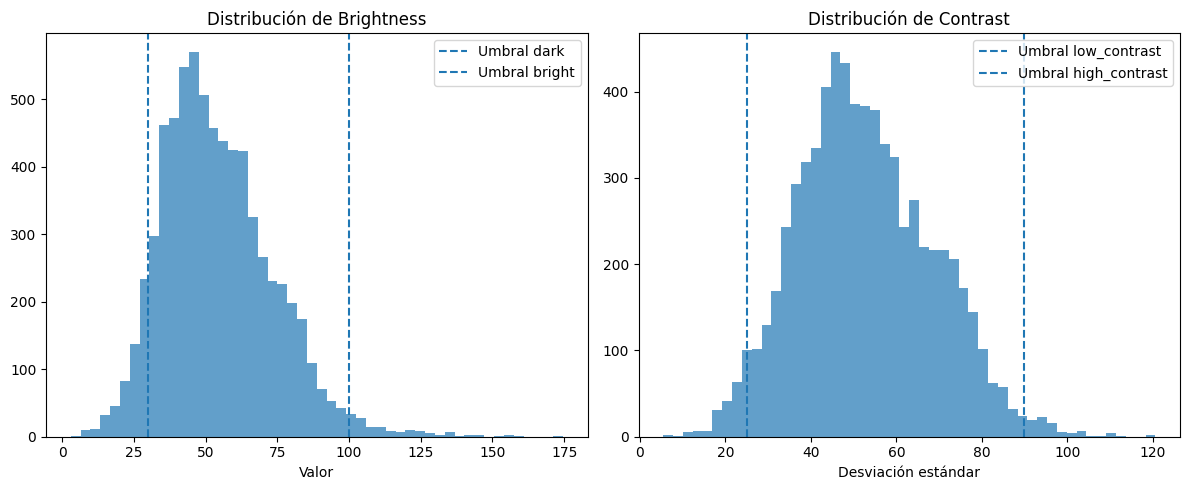

In [ ]:
# Umbrales (ajustables) los valores se han ajustado tras varias pruebas
THRESHOLDS = {
    'dark': 30,
    'low_contrast': 25,
    'bright': 100,
    'high_contrast': 90
}

def analyze_image(image_path):
    """
    Analiza la calidad de una imagen calculando brillo, contraste
    y detectando si está oscura, brillante, con bajo o alto contraste.
    """
    img = cv2.imread(image_path)
    if img is None: return None
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calcular brillo y contraste
    brightness, contrast = np.mean(gray), np.std(gray)
    
    return {
        'brightness': brightness,
        'contrast': contrast,
        'is_dark': brightness < THRESHOLDS['dark'],
        'is_bright': brightness > THRESHOLDS['bright'],
        'is_low_contrast': contrast < THRESHOLDS['low_contrast'],
        'is_high_contrast': contrast > THRESHOLDS['high_contrast'],
        'hist': cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
    }

def analyze_dataset(image_dir, sample_size=None):
    """
    Analiza un conjunto de imágenes y devuelve estadísticas de brillo y contraste.
    """
    paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
    paths = random.sample(paths, sample_size) if sample_size else paths
    
    categories = ['dark', 'low_contrast', 'bright', 'high_contrast']
    results = {k: [] for k in categories}
    results['all'] = []
    
    for path in tqdm(paths, desc="Analizando imágenes"):
        if analysis := analyze_image(path):
            results['all'].append(analysis)
            for cat in categories:
                if analysis[f'is_{cat}']: results[cat].append(path)
    
    stats = {
        'total': len(results['all']),
        **{f'{k}_images': len(v) for k, v in results.items() if k != 'all'},
        'mean_brightness': np.mean([r['brightness'] for r in results['all']]),
        'mean_contrast': np.mean([r['contrast'] for r in results['all']]),
        **{f'{k}_paths': v for k, v in results.items() if k != 'all'}
    }
    
    return stats, results['all']

# Visualización compacta
def plot_stats(results):
    """
    Muestra histogramas de la distribución de brillo y contraste en las imágenes analizadas.
    """
    metrics = ['brightness', 'contrast']
    thresholds = {
        'brightness': ('dark', 'bright'), 
        'contrast': ('low_contrast', 'high_contrast')
    }
    
    plt.figure(figsize=(12, 5))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 2, i)
        plt.hist([r[metric] for r in results], bins=50, alpha=0.7)
        for t in thresholds[metric]:
            plt.axvline(x=THRESHOLDS[t], linestyle='--', label=f'Umbral {t}')
        plt.title(f'Distribución de {metric.capitalize()}')
        plt.xlabel('Valor' if metric == 'brightness' else 'Desviación estándar')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Uso
stats, results = analyze_dataset("../ODIR-5K/ODIR-5K/Training Images")
print("\n=== RESUMEN ===")
[print(f"{k.replace('_', ' ').title()}: {v} ({v/stats['total']:.1%})") 
for k, v in stats.items() if k.endswith('images')]

plot_stats(results)

Parece que el contraste medio y el brillo son suficientemente altos, lo que habría que tener en cuenta para no aplicar transformaciones muy agresivas a todo el conjunto.

Se lleva a cabo un análisis automático de calidad de imagen, evaluando métricas de brillo y contraste en todas las fotografías del conjunto.
Mediante umbrales predefinidos, las imágenes se clasifican en categorías como oscuras, brillantes, bajo contraste o alto contraste.
Además, se generan distribuciones gráficas que permiten verificar si los valores de umbral son adecuados y estimar su impacto potencial en la correcta identificación de características relevantes de la retina por parte del modelo.


/var/folders/7z/6sq72d5x0s948s3fwhhpbthh0000gn/T/ipykernel_4256/2846364917.py:43: UserWarning: Glyph 27 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/retina/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


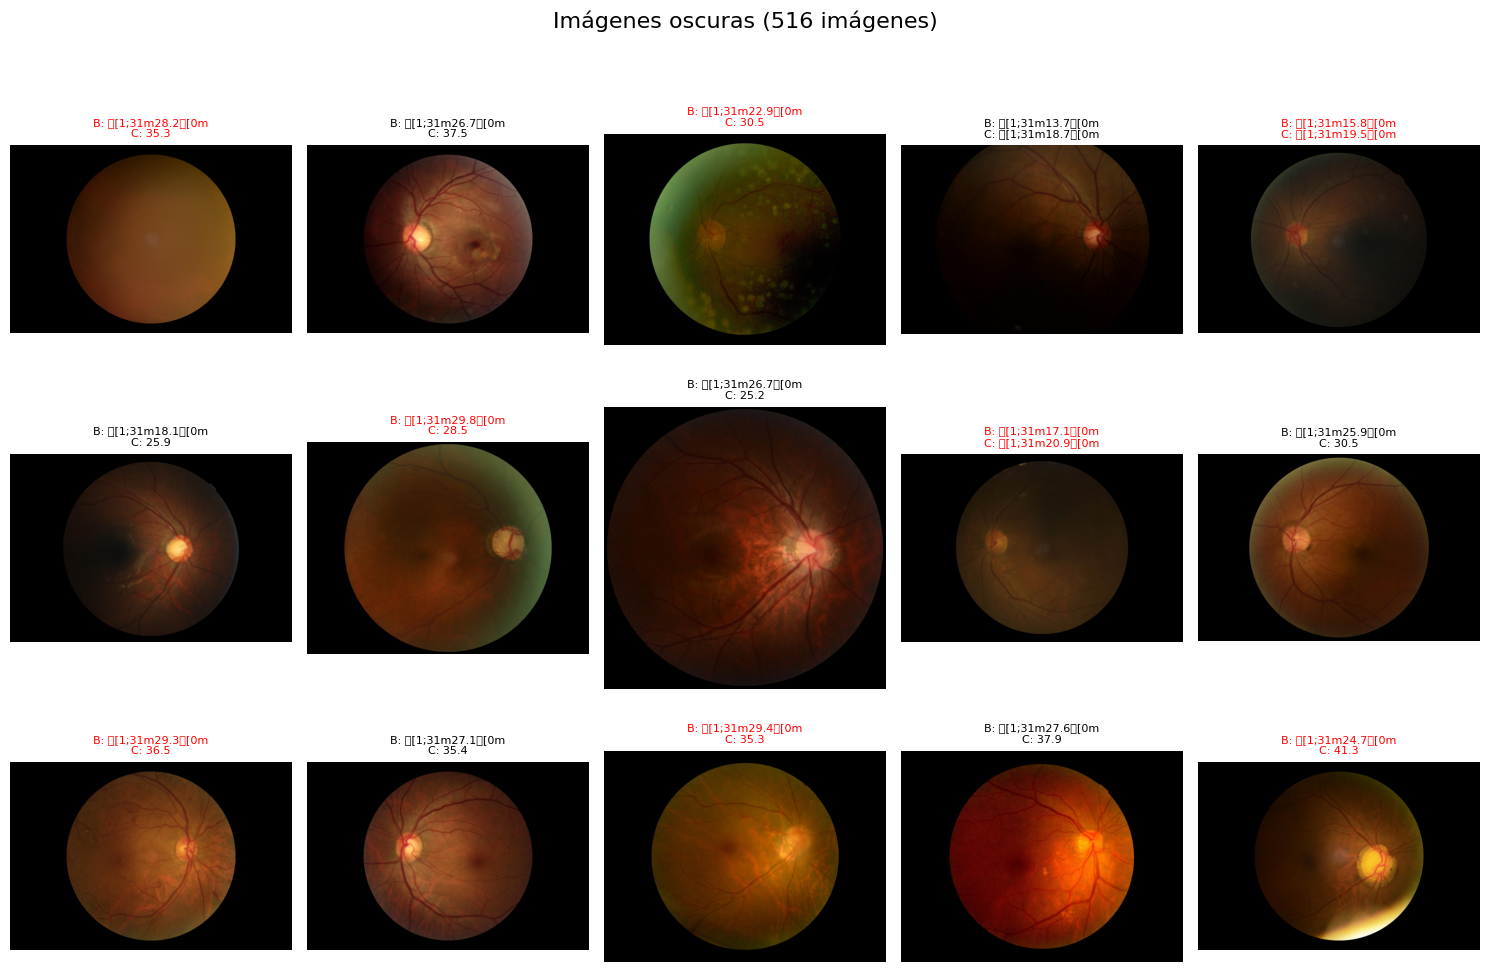

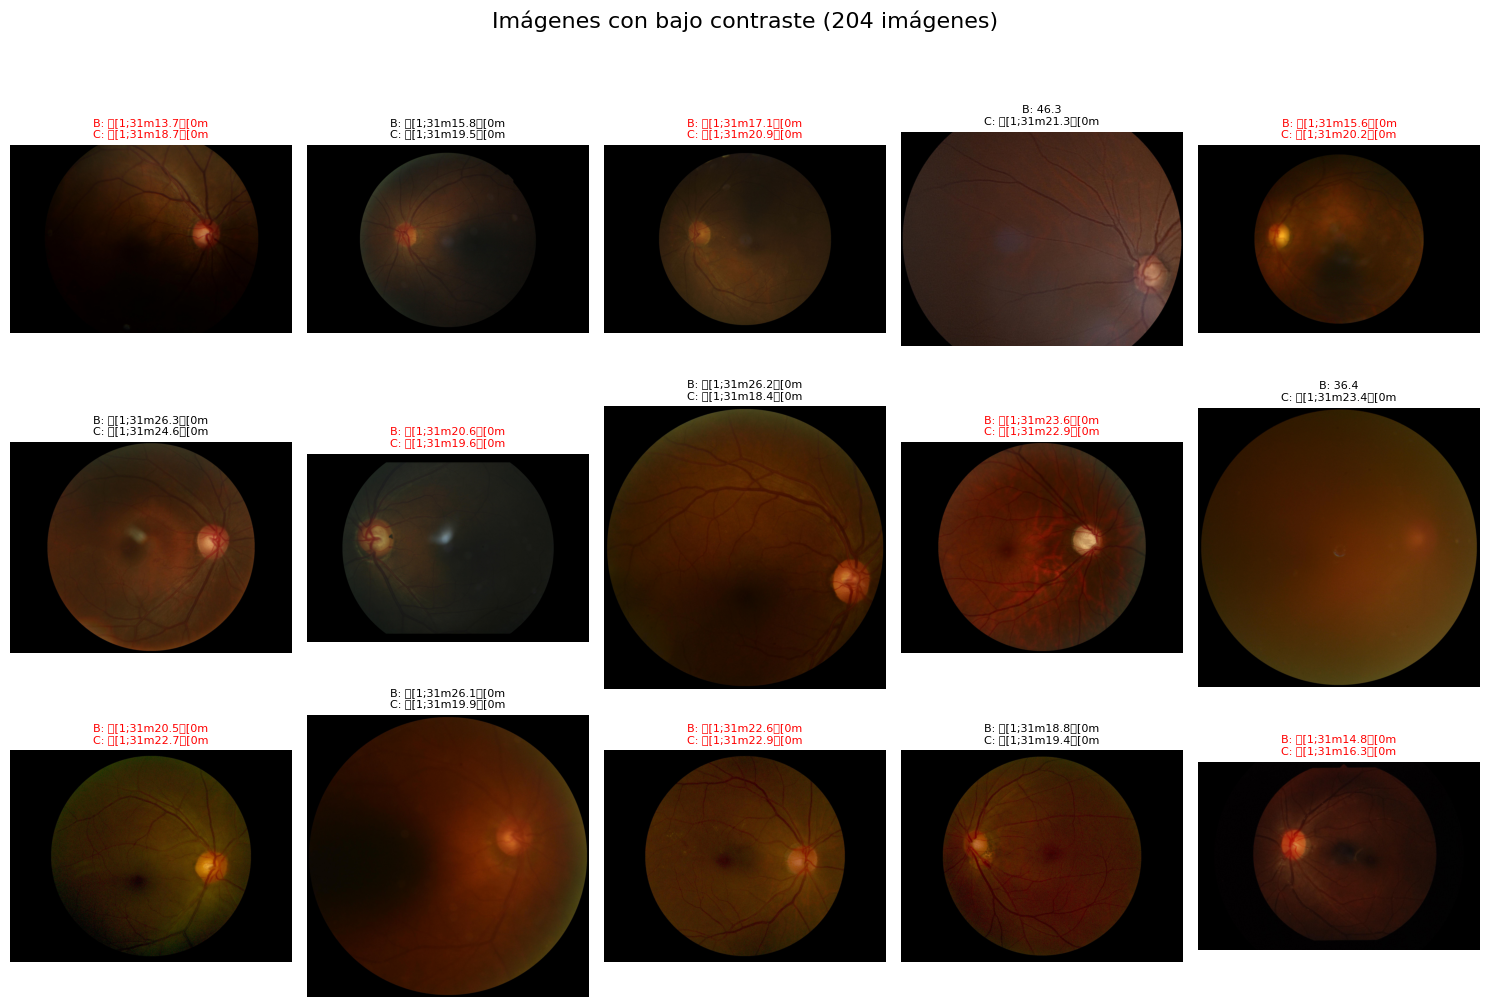

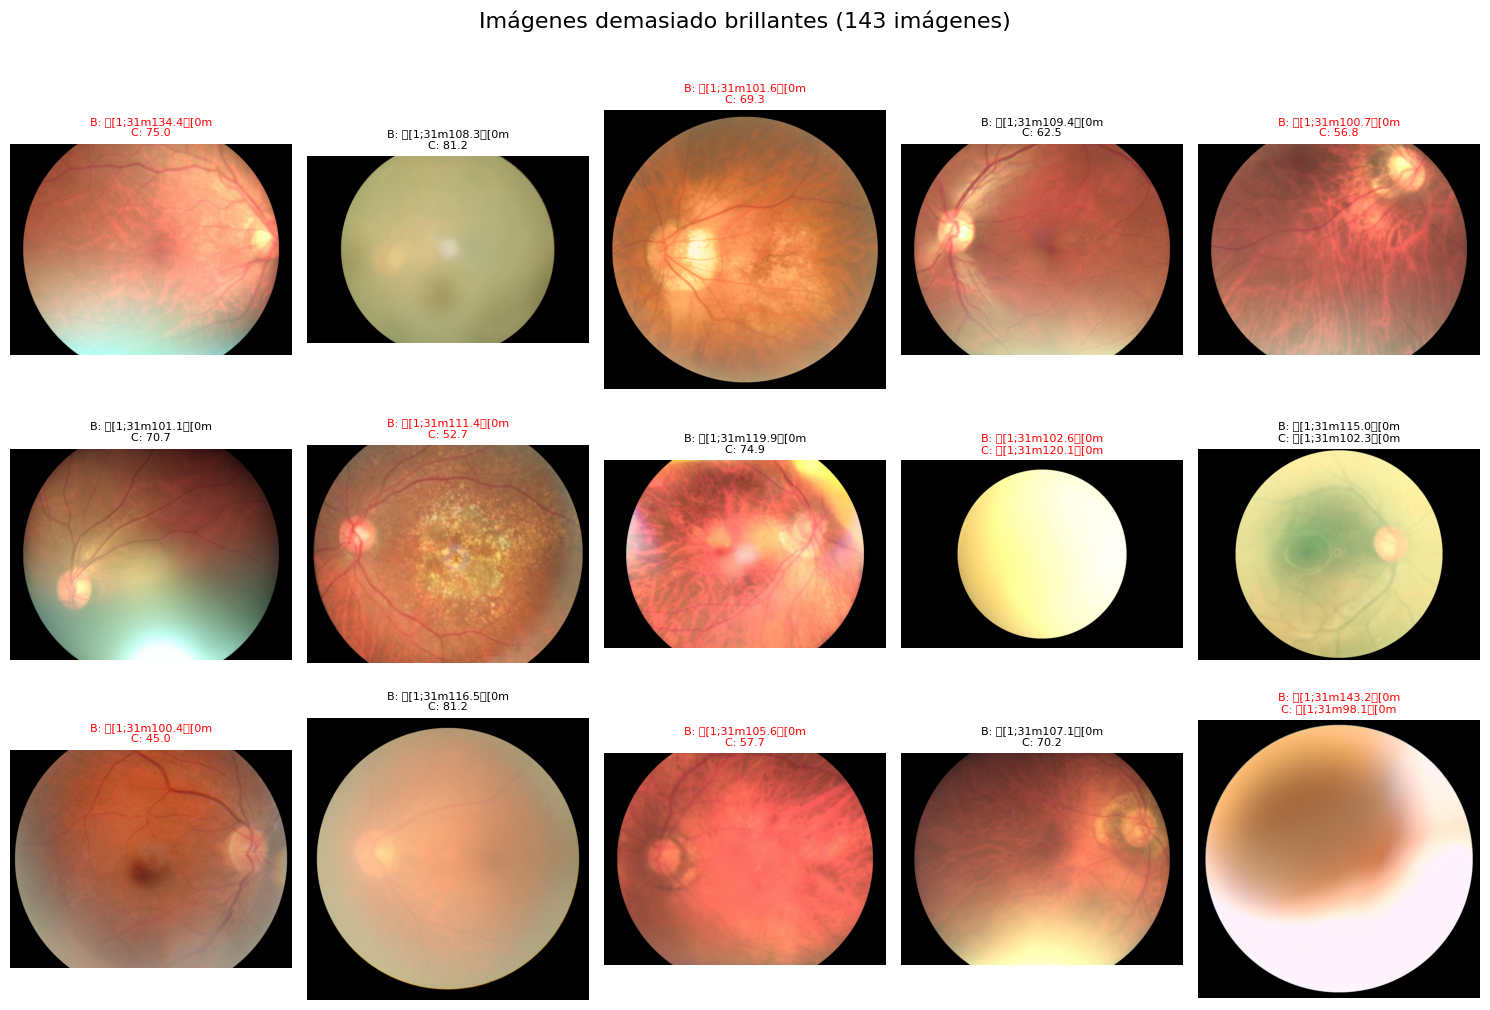

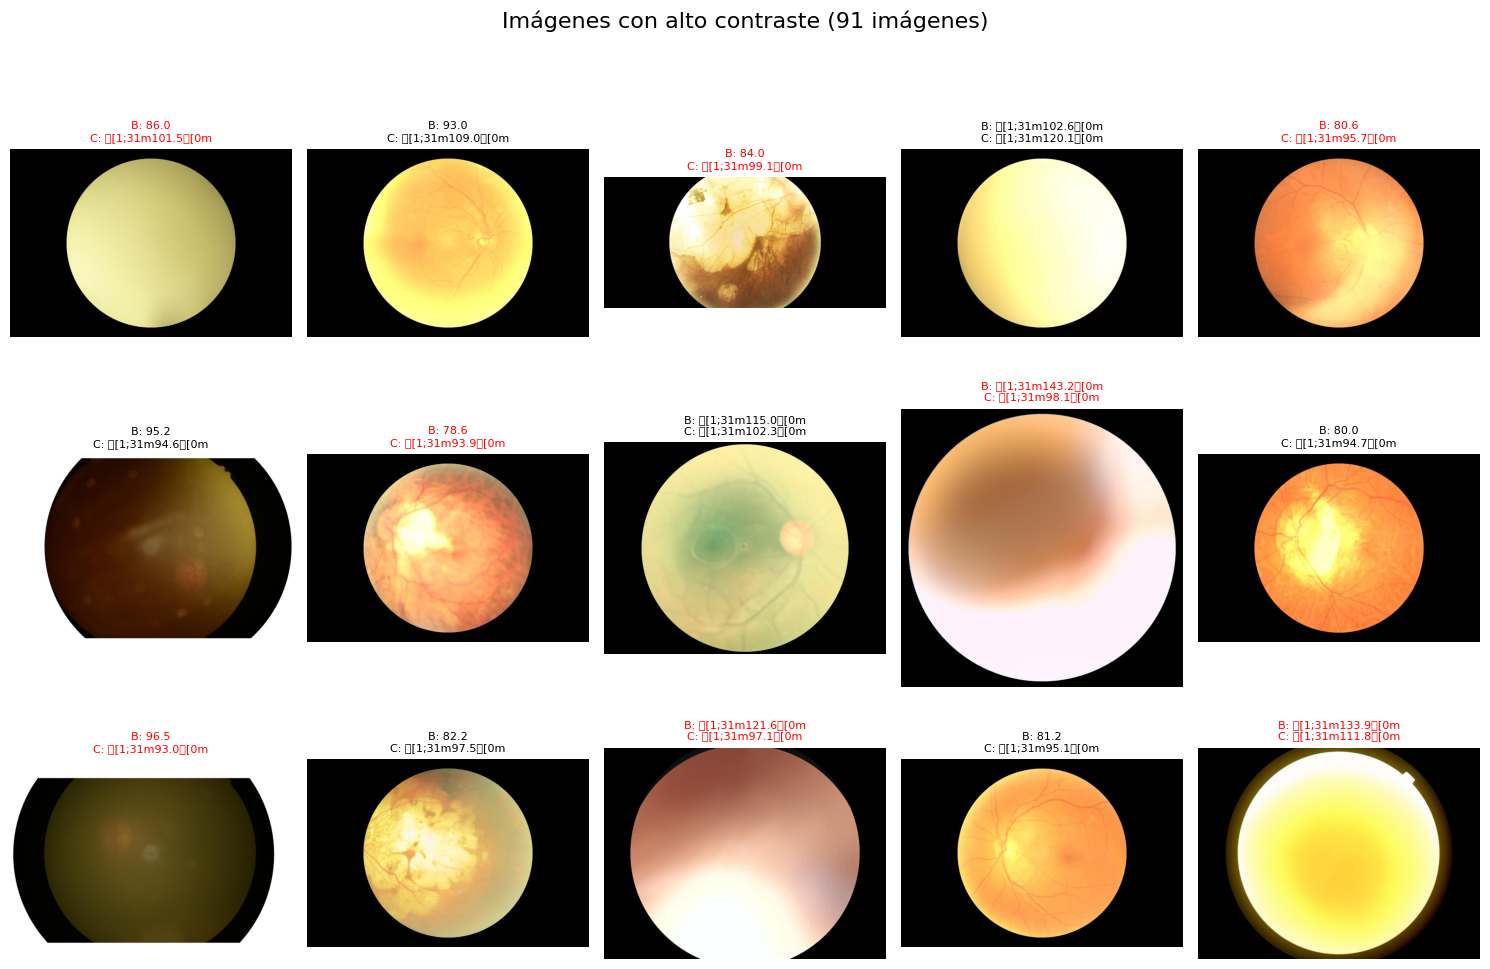

In [ ]:
def display_examples(image_paths, title, max_examples=15):
    """
    Muestra un grid con ejemplos de imágenes problemáticas junto a sus métricas.
    """
    if not image_paths:
        print(f"No hay imágenes para mostrar en la categoría: {title}")
        return
    
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"{title} ({len(image_paths)} imágenes)", y=1.02, fontsize=16)
    
    # Limitar el número de ejemplos y calcular el grid
    examples = image_paths[:max_examples]
    rows = int(np.ceil(len(examples)/5))
    
    for i, path in enumerate(examples, 1):
        plt.subplot(rows, 5, i)
        img = cv2.imread(path)
        if img is None:
            continue
            
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')
        
        # Calcular métricas
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness = np.mean(gray)
        contrast = np.std(gray)
        
        # Construir el título y color
        brightness_text = f"B: {brightness:.1f}"
        contrast_text = f"C: {contrast:.1f}"
        
        # Si la imagen es problemática, poner título en rojo
        if brightness < THRESHOLDS['dark'] or brightness > THRESHOLDS['bright']:
            brightness_text = f"B: \033[1;31m{brightness:.1f}\033[0m"
        if contrast < THRESHOLDS['low_contrast'] or contrast > THRESHOLDS['high_contrast']:
            contrast_text = f"C: \033[1;31m{contrast:.1f}\033[0m"
        
        plt.title(f"{brightness_text}\n{contrast_text}", fontsize=8, color='red' if i % 2 else 'black')
    
    plt.tight_layout()
    plt.show()

# Mostrar ejemplos de todas las categorías
categories = {
    'dark': "Imágenes oscuras",
    'low_contrast': "Imágenes con bajo contraste",
    'bright': "Imágenes demasiado brillantes", 
    'high_contrast': "Imágenes con alto contraste"
}

for category, title in categories.items():
    if stats[f'{category}_images'] > 0:
        display_examples(stats[f'{category}_paths'], title)

### Distribución de imágenes por clase diagnóstica según calidad

El objetivo de este análisis es detectar si determinadas patologías presentan una proporción elevada de imágenes con baja calidad visual, lo que podría afectar al aprendizaje del modelo y justificar la aplicación de técnicas de preprocesamiento específicas para las clases diagnósticas más afectadas.

In [ ]:
# Crear DataFrame de calidad de imagen
quality_data = []
label_cols = ["N", "D", "G", "C", "A", "H", "M", "O"]

for idx, row in df.iterrows():
    for side_col in ["Left-Fundus", "Right-Fundus"]:
        fname = row[side_col]
        if pd.isna(fname):
            continue
        
        img_path = os.path.join(image_dir, fname)
        analysis = analyze_image(img_path)
        
        if analysis:
            quality_data.append({
                "ID": row["ID"],  
                "side": side_col.replace("-Fundus", "").lower(),
                "filename": fname,
                "brightness": analysis["brightness"],
                "contrast": analysis["contrast"],
                "is_dark": analysis["is_dark"],
                "is_low_contrast": analysis["is_low_contrast"],
                "is_bright": analysis["is_bright"],                
                "is_high_contrast": analysis["is_high_contrast"], 
                **{c: row[c] for c in label_cols} 
            })

quality_df = pd.DataFrame(quality_data)

# Generar columna con etiquetas activas
def row_labels(r):
    active = [c for c in label_cols if r[c] == 1]
    return ",".join(active) if active else "N/A"

quality_df["labels_str"] = quality_df.apply(row_labels, axis=1)

print("DataFrame de calidad de imagen:", quality_df.shape)
quality_df.head()

DataFrame de calidad de imagen: (7000, 18)


ID   side     filename  brightness   contrast  is_dark  is_low_contrast  \
0   0   left   0_left.jpg   56.282630  49.723927    False            False   
1   0  right  0_right.jpg   33.274280  30.609474    False            False   
2   1   left   1_left.jpg   55.223706  66.064608    False            False   
3   1  right  1_right.jpg   53.834958  65.333838    False            False   
4   2   left   2_left.jpg   22.945099  30.494534     True            False   

   is_bright  is_high_contrast  N  D  G  C  A  H  M  O labels_str  
0      False             False  0  0  0  1  0  0  0  0          C  
1      False             False  0  0  0  1  0  0  0  0          C  
2      False             False  1  0  0  0  0  0  0  0          N  
3      False             False  1  0  0  0  0  0  0  0          N  
4      False             False  0  1  0  0  0  0  0  1        D,O

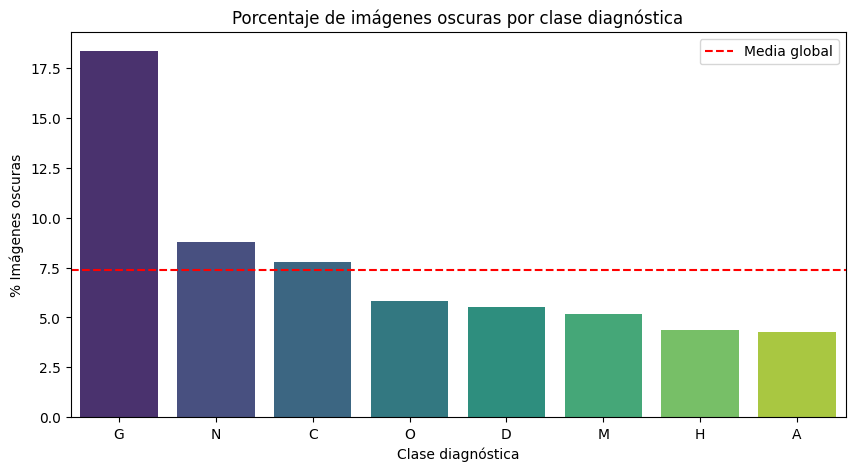

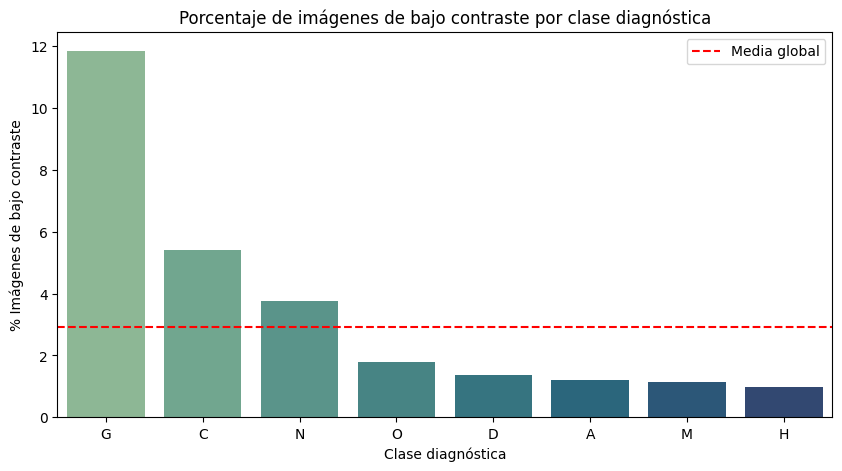

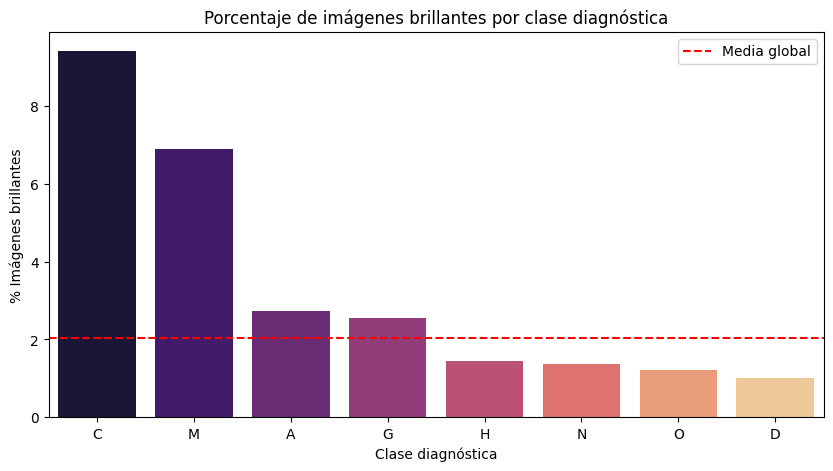

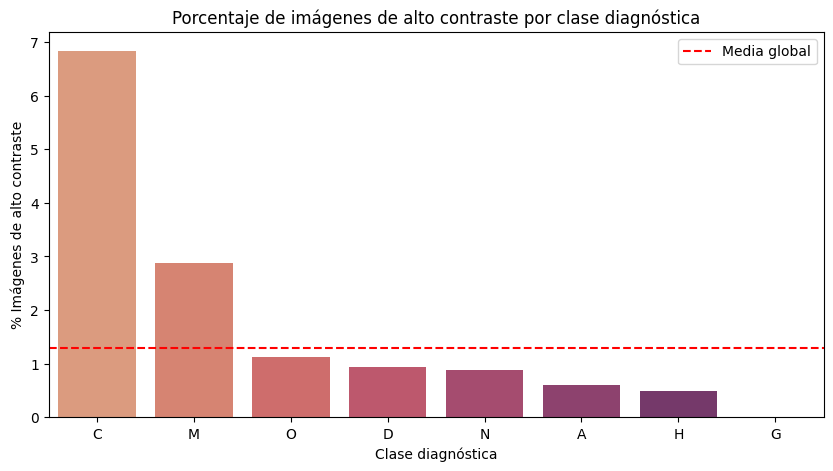

In [ ]:
# Lista de Clases diagnósticas
diseases = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# --- Imágenes oscuras ---
results_dark = []
for disease in diseases:
    total = quality_df[disease].sum()
    dark = quality_df[(quality_df[disease] == 1) & (quality_df['is_dark'])].shape[0]
    pct = (dark / total) * 100 if total > 0 else 0
    results_dark.append({'Disease': disease, 'Total': total, 'Count': dark, '%': pct})

pct_dark_df = pd.DataFrame(results_dark).sort_values('%', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='%', data=pct_dark_df, palette='viridis')
plt.title('Porcentaje de imágenes oscuras por clase diagnóstica') 
plt.xlabel('Clase diagnóstica') 
plt.ylabel('% Imágenes oscuras')
plt.axhline(y=quality_df['is_dark'].mean() * 100, color='red', linestyle='--', label='Media global')
plt.legend()
plt.show()

# --- Imágenes bajo contraste ---
results_low_contrast = []
for disease in diseases:
    total = quality_df[disease].sum()
    low_contrast = quality_df[(quality_df[disease] == 1) & (quality_df['is_low_contrast'])].shape[0]
    pct = (low_contrast / total) * 100 if total > 0 else 0
    results_low_contrast.append({'Disease': disease, 'Total': total, 'Count': low_contrast, '%': pct})

pct_low_contrast_df = pd.DataFrame(results_low_contrast).sort_values('%', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='%', data=pct_low_contrast_df, palette='crest')
plt.title('Porcentaje de imágenes de bajo contraste por clase diagnóstica') 
plt.xlabel('Clase diagnóstica') 
plt.ylabel('% Imágenes de bajo contraste')
plt.axhline(y=quality_df['is_low_contrast'].mean() * 100, color='red', linestyle='--', label='Media global')
plt.legend()
plt.show()

# --- Imágenes brillantes ---
results_bright = []
for disease in diseases:
    total = quality_df[disease].sum()
    bright = quality_df[(quality_df[disease] == 1) & (quality_df['is_bright'])].shape[0]
    pct = (bright / total) * 100 if total > 0 else 0
    results_bright.append({'Disease': disease, 'Total': total, 'Count': bright, '%': pct})

pct_bright_df = pd.DataFrame(results_bright).sort_values('%', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='%', data=pct_bright_df, palette='magma')
plt.title('Porcentaje de imágenes brillantes por clase diagnóstica') 
plt.xlabel('Clase diagnóstica') 
plt.ylabel('% Imágenes brillantes')
plt.axhline(y=quality_df['is_bright'].mean() * 100, color='red', linestyle='--', label='Media global')
plt.legend()
plt.show()

# --- Imágenes alto contraste ---
results_high_contrast = []
for disease in diseases:
    total = quality_df[disease].sum()
    high_contrast = quality_df[(quality_df[disease] == 1) & (quality_df['is_high_contrast'])].shape[0]
    pct = (high_contrast / total) * 100 if total > 0 else 0
    results_high_contrast.append({'Disease': disease, 'Total': total, 'Count': high_contrast, '%': pct})

pct_high_contrast_df = pd.DataFrame(results_high_contrast).sort_values('%', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='%', data=pct_high_contrast_df, palette='flare')
plt.title('Porcentaje de imágenes de alto contraste por clase diagnóstica') 
plt.xlabel('Clase diagnóstica') 
plt.ylabel('% Imágenes de alto contraste')
plt.axhline(y=quality_df['is_high_contrast'].mean() * 100, color='red', linestyle='--', label='Media global')
plt.legend()
plt.show()


En la gráfica anterior se observa que un porcentaje elevado de imágenes oscuras y de bajo contraste pertenece a la clase "Glaucoma", lo que sugiere que sería más adecuado, en caso de necesidad, intentar corregir su calidad mediante técnicas de mejora de imagen, en lugar de eliminarlas del conjunto de datos.

Además, se observa que las clases "Cataratas" (C) y "Fondo normal" (N) también presentan un porcentaje de imágenes oscuras ligeramente por encima de la media global.

Por otro lado las clases C (Cataract) y M (Macular disease) presentan los valores más altos tanto en el porcentaje de imágenes brillantes como en el de alto contraste. Esta sobreexposición y alto contraste podrían introducir sesgos visuales, haciendo que el modelo aprenda patrones más relacionados con las condiciones de iluminación. Se podría valorar usas técnicas de normalizaicón de brillo y contraste en el preprocesamiento.



In [ ]:
def plot_by_disease_and_category(disease, category, n_samples=5):
    """
    Muestra ejemplos de imágenes de una clase diagnóstica específica 
    que cumplen con una condición de calidad.
    
    Parámetros:                                                                                 
        disease (str): Código de la enfermedad (por ejemplo, 'G' para glaucoma).
        category (str): Categoría de calidad ('dark', 'bright', 'low_contrast', 'high_contrast').
        n_samples (int): Número de imágenes a visualizar (por defecto 5).
    """
    # Filtrar imágenes por clase y condición
    samples = quality_df[
        (quality_df[disease] == 1) & 
        (quality_df[f'is_{category}'])
    ].sample(min(n_samples, quality_df.shape[0]))

    # Visualización
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(image_dir, row['filename'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n_samples, i+1)
        plt.imshow(img)
        plt.title(f"B:{row['brightness']:.1f} | C:{row['contrast']:.1f}\n{row['labels_str']}", fontsize=8)
        plt.axis('off')

    plt.suptitle(f'Imágenes "{category}" - Clase {disease}', y=1.05)
    plt.show()

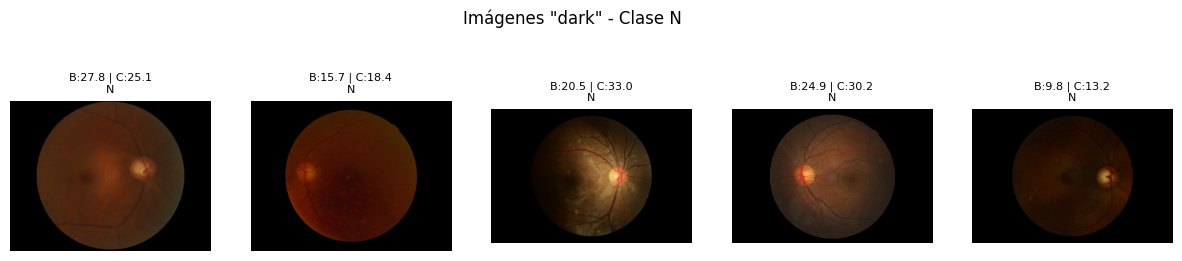

In [ ]:
# Ejemplo para clase Normal ('N')
plot_by_disease_and_category('N', 'dark')

In [ ]:
# Tabla informativa de calidad visual por clase diagnóstica
# Combinar todas las métricas en un único DataFrame
quality_table= (
    pct_dark_df.merge(pct_low_contrast_df, on='Disease', suffixes=('_dark', '_low_contrast'))
               .merge(pct_bright_df, on='Disease', suffixes=('', '_bright'))
               .merge(pct_high_contrast_df, on='Disease', suffixes=('', '_high_contrast'))
)

quality_table_simple = quality_table[[
    'Disease',                     
    'Total_dark',               
    'Count_dark', '%_dark',         
    'Count_low_contrast', '%_low_contrast',  
    'Count', '%',                   
    'Count_high_contrast', '%_high_contrast' 
]].copy()

# Mostrar la tabla final
quality_table

Disease  Total_dark  Count_dark     %_dark  Total_low_contrast  \
0       G         430          79  18.372093                 430   
1       N        2280         200   8.771930                2280   
2       C         424          33   7.783019                 424   
3       O        1958         114   5.822268                1958   
4       D        2256         125   5.540780                2256   
5       M         348          18   5.172414                 348   
6       H         206           9   4.368932                 206   
7       A         328          14   4.268293                 328   

   Count_low_contrast  %_low_contrast  Total_bright  Count         %  \
0                  51       11.860465           430     11  2.558140   
1                  86        3.771930          2280     31  1.359649   
2                  23        5.424528           424     40  9.433962   
3                  35        1.787538          1958     24  1.225741   
4                  31        1.374113          2256     23  1.019504   
5                   4        1.149425           348     24  6.896552   
6                   2        0.970874           206      3  1.456311   
7                   4        1.219512           328      9  2.743902   

   Total_high_contrast  Count_high_contrast  %_high_contrast  
0                  430                    0         0.000000  
1                 2280                   20         0.877193  
2                  424                   29         6.839623  
3                 1958                   22         1.123596  
4                 2256                   21         0.930851  
5                  348                   10         2.873563  
6                  206                    1         0.485437  
7                  328                    2         0.609756


Hay que tener en cuenta el desequilibrio en la calidad de las imágenes, ya que podría ser necesario aplicar estrategias de preprocesado específicas por clase, como `ColorJitter (brightness, contrast)`, especialmente para Glaucoma, antes de descartar imágenes potencialmente útiles. 

A continuación mostramos un boxplot que muestra la distribución del brillo de las imágenes según la presencia o ausencia de cada enfermedad. los colores diferencia si la imagen tiene o no la enfermedad (1: la tiene, o: no la tiene).

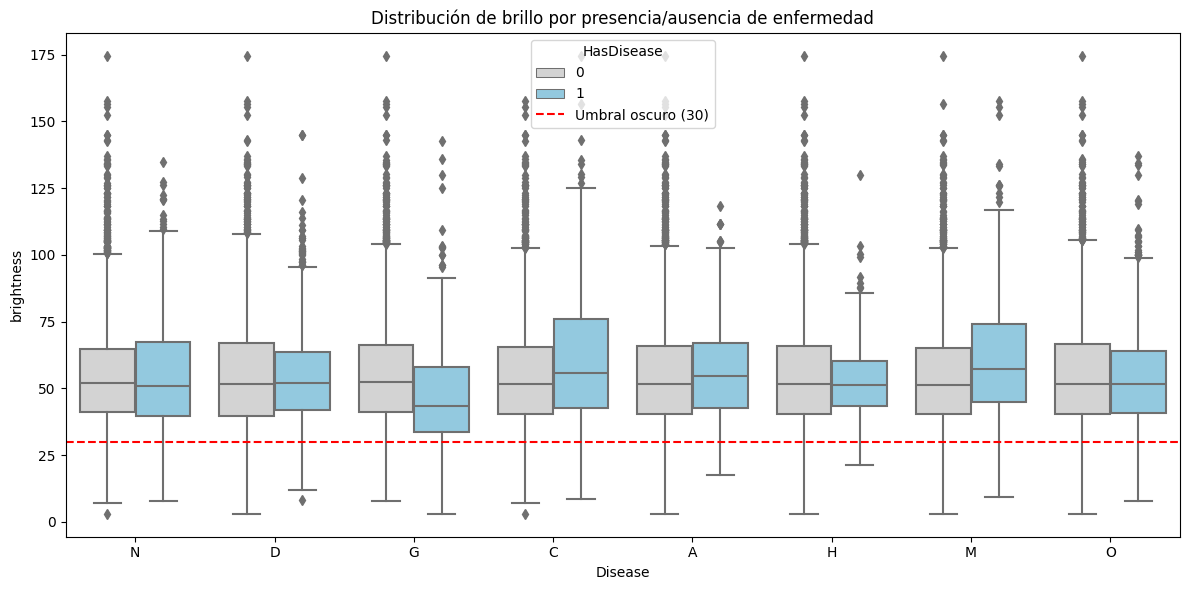

In [ ]:
# Visualización de la distribución de brillo por presencia/ausencia de enfermedad
# Lista de clases diagnósticas
label_cols = ["N", "D", "G", "C", "A", "H", "M", "O"]

# Reorganizar el DataFrame para análisis por enfermedad
plot_df = quality_df.melt(
    id_vars=['brightness'],
    value_vars=label_cols,
    var_name='Disease',
    value_name='HasDisease'
)

# Creamos el gráfico
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=plot_df,
    x='Disease',
    y='brightness',
    hue='HasDisease',
    palette={0: 'lightgray', 1: 'skyblue'}  # 0 = sin enfermedad, 1 = con enfermedad
)

# Línea de referencia para el umbral de imágenes oscuras
plt.axhline(
    y=THRESHOLDS['dark'], 
    color='red', 
    linestyle='--', 
    label=f"Umbral oscuro ({THRESHOLDS['dark']})"
)

plt.title('Distribución de brillo por presencia/ausencia de enfermedad')
plt.legend(title='HasDisease')
plt.tight_layout()
plt.show()


Aplicamos un test estadístico (t-test independiente) para comparar si hay diferencias significativas en el brillo medio entre imágenes con y sin cada una de las enfermedadades.

In [ ]:
# Comparación de brillo entre grupos con y sin enfermedad
# Lista de columnas de etiquetas binarias
label_cols = ["N", "D", "G", "C", "A", "H", "M", "O"]

def compare_brightness_simple(quality_df, diseases):
    """
    Compara el brillo medio entre imágenes con y sin cada enfermedad usando prueba t de Welch.
    
    Parámetros:
    - quality_df: DataFrame con columnas 'brightness' y las enfermedades como columnas binarias (0/1)
    - diseases: lista con los nombres de las columnas de enfermedades
    """
    rows = []
    for d in diseases:
        # Brillo para imágenes con la enfermedad
        g1 = quality_df.loc[quality_df[d] == 1, 'brightness'].dropna()
        # Brillo para imágenes sin la enfermedad
        g0 = quality_df.loc[quality_df[d] == 0, 'brightness'].dropna()
        
        # Prueba t de Welch
        t_stat, p_val = ttest_ind(g1, g0, equal_var=False)
        
        # Añadir resultados
        rows.append({
            'Disease': d,
            'n_with': len(g1),
            'n_without': len(g0),
            'mean_brightness_with': g1.mean(),
            'mean_brightness_without': g0.mean(),
            'mean_diff': g1.mean() - g0.mean(),
            'p_value': p_val
        })
    
    # Ordenar por p-valor
    out = pd.DataFrame(rows).sort_values('p_value').reset_index(drop=True)
    return out

# Ejecutar y mostrar resumen
brightness_summary = compare_brightness_simple(quality_df, label_cols)
brightness_summary

Disease  n_with  n_without  mean_brightness_with  mean_brightness_without  \
0       G     430       6570             47.153985                54.791603   
1       M     348       6652             61.774808                53.932563   
2       C     424       6576             60.717444                53.910104   
3       D    2256       4744             53.668784                54.633277   
4       A     328       6672             56.306822                54.224881   
5       O    1958       5042             53.665720                54.577462   
6       H     206       6794             52.902294                54.365495   
7       N    2280       4720             53.956895                54.499009   

   mean_diff       p_value  
0  -7.637618  4.198443e-13  
1   7.842244  5.671560e-09  
2   6.807340  2.589297e-07  
3  -0.964492  3.540790e-02  
4   2.081941  4.815625e-02  
5  -0.911742  6.112338e-02  
6  -1.463200  1.933679e-01  
7  -0.542113  2.733112e-01

Perece que hay evidencia estadística de que algunas enfermedades se asocian con diferencias en el brillo medio:

Imágenes de pacientes con glaucoma son significativamente más oscuras, mientras que las de paciente de cataratas o miopía son significativamente más claras.


## Propuestas a valorar para la transformación de imágenes, creación de Dataloader y arquitectura

### 1. Posible eliminación de las imágenes consideradas oscuras 

- Total afectado: **620 imágenes** (~**7,8%** del total).
- Recomendación: **no eliminar directamente** si el porcentaje de imágenes oscuras se concentra en una clase concreta (por ejemplo, la clase 'G' de glaucoma), ya que podríamos introducir un sesgo.
- Alternativas:
  - Aplicar transformaciones como `ColorJitter(brightness)` para mejorar el brillo.
  - Usar `sample_weight` para reducir su influencia en el entrenamiento en lugar de eliminarlas.

---

### 2. Mejora mediante ecualización CLAHE

_Aplicable sobre el dataset completo o solo sobre imágenes de bajo contraste._

**Ventajas:**
- Mejora la visibilidad de características poco evidentes como **microaneurismas, exudados o neovasos**.
- Ajusta el contraste local por zonas.
- Puede mejorar también el brillo (aunque en general ya se encuentra en valores aceptables).

**Desventajas:**
- Puede aumentar el ruido visual y producir falsos positivos.
- Requiere ajuste de parámetros como el *clip limit*.
- Su efecto puede ser limitado sin segmentación previa.
- No siempre mejora el rendimiento del modelo.

---

### 3. Tamaño de redimensionamiento de las imágenes

- El tamaño más frecuente es **(1728, 2592, 3)** → **~30% del total**.

**Consideraciones:**

- **Redimensionar a ese tamaño no es recomendable**:
  - Muy costoso computacionalmente.
  - Puede forzar al modelo a aprender detalles irrelevantes y sobreajustar.

- **Alternativas realistas**:
  - `1024 x 1024`: Fine-tuning en modelos propios.
  - `896 x 1344`: Proporción ≈ 2:3, útil si se entrena desde cero.
  - **Tamaños redes pre-entrenada**:
    - `224×224` → ResNet18, MobileNet
    - `380×380` → EfficientNet-B4

> Importante: **Definir primero la arquitectura** y luego adaptar el tamaño. Alinear ambos para evitar incompatibilidades o pérdida de detalle.

---

### 4. Tipo de redimensionamiento

Comparativa de métodos:

- **`cv2.resize`**:
  - Redimensionamiento directo.
  - Puede **deformar** la imagen → No recomendable.

- **Resize + padding**:
  - Ajusta sin deformar.
  - Introduce **bordes artificiales** → ruido visual.

- **`transforms.Resize` + `CenterCrop`**:
  - Mantiene la proporción.
  - Preserva la región central sin relleno artificial.
  - Preferible para preservar la forma y estructura anatómica.

---

### 5. Simetría de las imágenes

- Asegurar que las imágenes de ojo izquierdo y derecho estén correctamente orientadas.
- Aplicar `RandomHorizontalFlip()` y `RandomRotation()`como técnicas de aumento para prevenir el sobreajuste direccional y mejorar la robustez del modelo.

---

### 6. Aumento cromático (ColorJitter)

- Dado que un **12% de imágenes tiene bajo contraste**, se podría aplicar `ColorJitter(contrast, saturation)` con moderación o solo a ls imágenes identificadas de bajo contraste.
- Riesgo: **colores artificiales no representativos** si se abusa.

---

### 7. Balanceo de clases

Opciones recomendadas:

- `WeightedRandomSampler` en el `DataLoader`.
- Pérdida ponderada (`class_weight` en PyTorch o Sklearn).
- Oversampling de clases minoritarias.

---

### 8. Normalización por canal RGB

- Tener en cuenta que alunos modelos preentrenados (ResNet, EfficientNet) requieren normalización de las imágenes.
